# Operability analysis of a multistage membrane separation process for direct air capture (m-DAC) using AVEVA Process Simulation 

To address the impacts of fossil fuel emissions on climate change, CO<sub>2</sub> capture has been expanded from point-source capture to CO<sub>2</sub> removal from the atmosphere. The figure shows the direct air capture process, which utilizes gas separation membranes for the CO<sub>2</sub> removal. 


![m-DAC Process flow diagram](m-DAC_ProcessPFD.png)

# Process Overview: Multistage Membrane-Based Direct Air Capture (DAC) 
<p>
This process is designed for <strong>direct air capture (DAC) of CO<sub>2</sub></strong>, using a multistage membrane separation approach 
to concentrate carbon dioxide from atmospheric levels (~420 ppm) to a <strong>low-purity product (~5% CO<sub>2</sub> molar fraction)</strong>. 
The system is engineered to handle approximately <strong>1 megaton of air per year</strong>, aligning with urgent 
climate action goals.
</p>
<p>
The final CO<sub>2</sub>-enriched stream is suitable for applications that tolerate lower purity, such as:
<ul>
    <li>Algae cultivation</li>
    <li>Mineral carbonation processes</li>
</ul>
</p>

Key operations include vacuuming the permeate using vacuum pumps, compressors to restore pressure, and heat exchangers to maintain temperatures to acceptable ranges in order to avoid membrane degradation `Gama2024` .  


# Step-by-step set up of Opyrability with AVEVA Process Simulation 

## Step 1: Necessary imports for connection with APS and for Operability computations:

<h4> APS connection import</h4>

In [1]:
import simcentralconnect #AVEVA PROCESS SIMULATION REQUIRED IMPORT TO ENABLE CONNECTION

<color><red><i>This import is essential to enable communication with APS. Once you have installed and configured your APS, you should be able to find the Scripting Interface files. In it, a step-by-step README file guides the user through enabling the connection.</i></color></red>

In [2]:
import numpy as np
from opyrability import AIS2AOS_map, multimodel_rep, OI_eval #Operability algorigthms import from Opyrability library
from scipy.io import savemat

# Instantiating the required interfaces for the scripting interface

sc = simcentralconnect.connect().Result
sm = sc.GetService("ISimulationManager")
vm = sc.GetService("IVariableManager")
snap = sc.GetService("ISnapshotManager")

# Example of how to set options.  API logging is ON by default.  Disabled by changing to 'false'
sc.SetOptions(repr({'Timeout': 500000, 'EnableApiLogging': 'false'}))

SimCentral.Client.Auto loaded from: C:\Program Files\SimSci\SimCentral\Scripting\DotNetFwk


## Step 2: Calling the simulation file you want to work with:

In [4]:
simFile = "APS_mDAC"
simName = "APS_mDAC" #WARNING: Sometimes APS might rename your simulation as its opened so always make sure the name of the simulation you are working with aligns with the current opened simulation
nameSnap_FM = "steady" #Note: This is only required in case the user wants to set the simulation to a specific snapshot (Forward mapping case snapshot)
nameSnap_MR = "steady2" #Note: This is only required in case the user wants to set the simulation to a specific snapshot (Multimodel representation case snapshot)

## Step 3: Function for double checking if simulation exists:

In [5]:
def open_simulation(simName):
    opened = False
    try:
        opened = sm.OpenSimulation(simName).Result         
    except System.AggregateException as ex:
        if not isinstance(ex.InnerException, System.InvalidOperationException) \
                or "simulation doesn't exists" not in ex.InnerException.Message:
            raise
    return opened



open_simulation(simName)

True

## Step 4: Process model function to communicate with APS and Opyrability:

This function is the core of the operability analysis performed. In it, we are able to manipulate the membrane parameters mentioned in the following section (<b>Step 5</b>), and collected the achievable outcomes.

In [9]:
def M(u):

    y = np.zeros(2) #Prealocating outputs
     
    # Membrane properties case - First membrane module study

    # --------- Restarting simulation snapshot before changes -----------------------------
        
    snap.RevertSnapshot(simName,nameSnap_FM)

    #Parameters required for SetVariable method vm.SetVariableValue(<string> simulation name, <object> variable, <object> value, <object> unit, <object> apiOptions)(more on methods and interfaces is available in the AVEVA Scripting Interface documentation)
    vm.SetVariableValue(simName, "MDAC1.QCO2", u[0], "", ).Result 
    vm.SetVariableValue(simName, "MDAC2.QCO2", u[1], "", ).Result

    # --------- Checking solution status ----------------------------- 

    print(f"\nCalling simulation with inputs: {u}")
    try:
        status = sm.GetSimulationStatus(simName).Result #Retrieving solution status of the simulation. Argument [2] holds the boolean value that informs if the solver was capable to solve (True) or not (False) the simulation.
        print(f"Initial simulation status: {str(status[2])}")
    except Exception as e:
        print("Failed to get simulation status:", e) 

    if (status[2]):
        flag_conv = True
    else:
        flag_conv= False

    if flag_conv is True:
        
        # ------------------ PRODUCTIVITY VARIABLES -----------------------------------------

        Feed_flow = vm.GetVariableValue(simName, "Air_feed.F", "kmol/h").Result         
        Permeate = vm.GetVariableValue(simName, "Product.F", "kmol/h", ).Result            
        Purity =  vm.GetVariableValue(simName, "Product.z[CO2]", "mol frac", ).Result       

        # ---------------- AOS VARIABLES --------------------------------------------------
                
        # -------------------- Purity vs. Recovery case study ----------------------
        y[0] = Purity*100
        y[1] = 100*((Permeate*Purity) / (Feed_flow*0.000420))
        
    else:
            # --------- Restarting solver to try again -----------------------------
        
            snap.RevertSnapshot(simName,nameSnap_FM)

            # --------- Checking solution status again-----------------------------   
                
            status = sm.GetSimulationStatus(simName).Result

            print(u[0], u[1],"failed")
            if (status[2]):
                flag_conv = True
            else:
                flag_conv= False
            
            if flag_conv is True:
                            
                # ------------------- MEMBRANE PROPERTIES CASE -------------------------------
                
                #First membrane module study
                                
                vm.SetVariableValue(simName, "MDAC1.QCO2", u[0], "", ).Result
                vm.SetVariableValue(simName, "MDAC2.QCO2", u[1], "", ).Result
            
                       
                # ------------------ PRODUCTIVITY VARIABLES -----------------------------------------

                Feed_flow = vm.GetVariableValue(simName, "Air_feed.F", "kmol/h").Result         
                Permeate = vm.GetVariableValue(simName, "Product.F", "kmol/h", ).Result            
                Purity =  vm.GetVariableValue(simName, "Product.z[CO2]", "mol frac", ).Result                
   
                
                # ---------------- AOS VARIABLES --------------------------------------------------
                
                # -------------------- Purity vs. Recovery case study ----------------------
                y[0] = Purity*100
                y[1] = 100*((Permeate*Purity) / (Feed_flow*0.000420))              
                
            else:
                pass
            
            
    return y #Returning outputs for the Operability study

## Step 5: Defining Operability study

The current case study aims to analyze how the membrane's CO<sub>2</sub> permeance on both modules affect the overall capture of CO<sub>2</sub> in terms of its purity and recovery.

| Input (AIS)               | Output (AOS)                 |
|---------------------------|------------------------------|
| CO<sub>2</sub> Permeance (Membrane module 1) [GPU]  | CO<sub>2</sub> purity [mol%] |
| CO<sub>2</sub> Permeance (Membrane module 2) [GPU]    | CO<sub>2</sub> recovery [%]  |


Calling simulation with inputs: [0. 0.]
Initial simulation status: True

Calling simulation with inputs: [3.35e-08, 3.35e-08]
Initial simulation status: True

Calling simulation with inputs: [7.742222222222222e-07, 3.35e-08]
Initial simulation status: True

Calling simulation with inputs: [1.5149444444444445e-06, 3.35e-08]
Initial simulation status: True

Calling simulation with inputs: [2.255666666666667e-06, 3.35e-08]
Initial simulation status: True

Calling simulation with inputs: [2.9963888888888892e-06, 3.35e-08]
Initial simulation status: True

Calling simulation with inputs: [3.7371111111111116e-06, 3.35e-08]
Initial simulation status: True

Calling simulation with inputs: [4.477833333333333e-06, 3.35e-08]
Initial simulation status: True

Calling simulation with inputs: [5.2185555555555555e-06, 3.35e-08]
Initial simulation status: True

Calling simulation with inputs: [5.959277777777778e-06, 3.35e-08]
Initial simulation status: True

Calling simulation with inputs: [6.7e-06, 3.

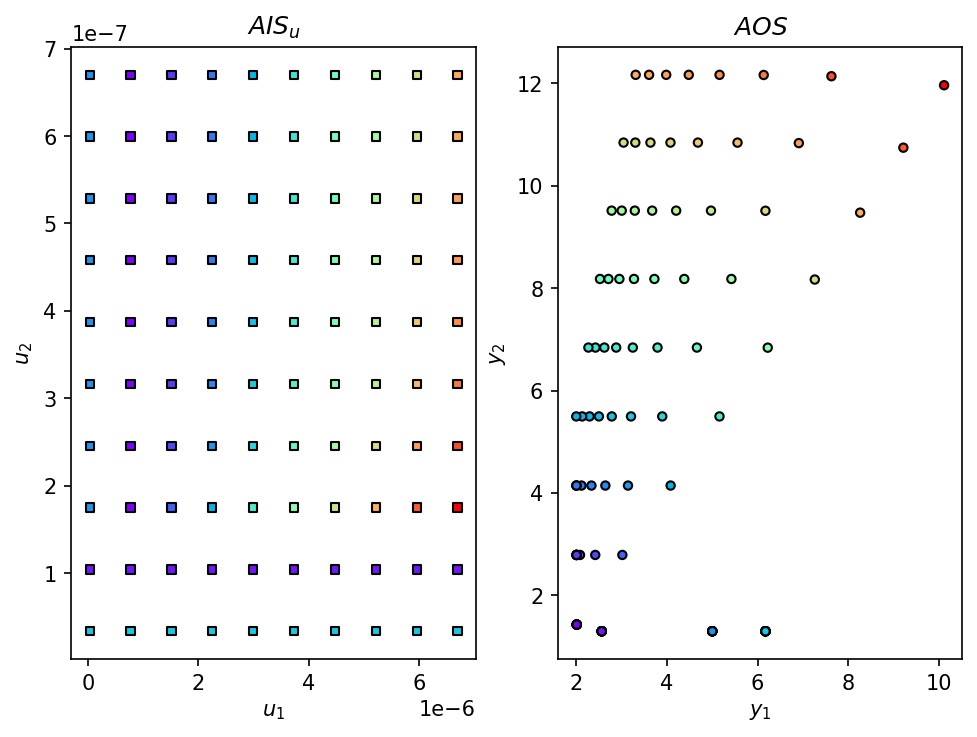

In [10]:
#---------------------- OPERABILIY STUDY --------------------------------------------------

AIS_bounds =  np.array([[3.35e-8, 6.7e-06],[3.35e-8, 6.7e-07]]) #AIS bounds definition for the 2 inputs x 2 outputs case study
AIS_resolution =  [10,10] #AIS discretization definition for the 2 inputs x 2 outputs case study
AIS, AOS = AIS2AOS_map(M, AIS_bounds, AIS_resolution) #Forwad mapping call for the 2 inputs x 2 outputs case study

In the figure above, the left plot depicts the Available Input Space (AIS​), where the axes correspond to the CO<sub>2</sub> permeance of each membrane module (u<sub>1</sub> = membrane module 1 and u<sub>2</sub> = membrane module 2). The right plot shows the Achievable Output Space (AOS), with axes representing the key performance indicators: CO<sub>2</sub> purity in mol% (y<sub>1</sub>​) and CO<sub>2</sub> recovery in % (y<sub>2</sub>​​). The color gradient establishes a visual mapping between input conditions and their resulting output performance, allowing us to trace how variations in intrinsic membrane properties affect process-level outcomes.

Interestingly, the results reveal a nonlinear relationship between inputs and outputs, where intermediate values of membrane permeance yield the most favorable performance. This emphasizes the importance of exploring the full design space rather than assuming monotonic improvements with increasing property values.

Overall, the operability analysis, performed here using the Opyrability framework, demonstrates its ability to not only determine whether a process can meet specific targets, but also evaluate how reliably and robustly it performs under varying input conditions and potential disturbances. In this case, it allows for a clear visualization of how membrane design choices, such as permeance values of individual modules translate into broader process performance metrics like CO<sub>2</sub> recovery and purity, aiding both material selection and system-level optimization.




# Multimodel representation

This section covers the application of another feature of the Opyrability package, the multimodel respresentation. With it, it is possible to generate an AOS a visualization using paired polytopes, which could assist in effective Operability Index (OI) calculations. Which in turn, can inform the researcher/engineer/practitioner how operable is the process considering different design or control structures.

## Process model function for Multimodel case:

For this particular case the process function was adapted to take advantage of the knowledge the multimodel approach can provide on different design decisions. The input variables here, as shown in following table, are more directly related to the membrane module construction, and later on, using the OI calculation we can discuss further on how the process performs under a Desired Region of Operation (DOS).

In [6]:
def Multi(u):

    y = np.zeros(2) #Prealocating outputs
     
    # Membrane properties case - First membrane module study

    # --------- Restarting simulation snapshot before changes -----------------------------
        
    snap.RevertSnapshot(simName,nameSnap_MR)

    #Parameters required for SetVariable method vm.SetVariableValue(<string> simulation name, <object> variable, <object> value, <object> unit, <object> apiOptions)(more on methods and interfaces is available in the AVEVA Scripting Interface documentation)
    vm.SetVariableValue(simName, "MDAC1.Nt", u[0], "", ).Result 
    vm.SetVariableValue(simName, "MDAC2.Nt", u[1], "", ).Result

    # --------- Checking solution status ----------------------------- 

    print(f"\nCalling simulation with inputs: {u}")
    try:
        status = sm.GetSimulationStatus(simName).Result #Retrieving solution status of the simulation. Argument [2] holds the boolean value that informs if the solver was capable to solve (True) or not (False) the simulation.
        print(f"Initial simulation status: {str(status[2])}")
    except Exception as e:
        print("Failed to get simulation status:", e) 

    if (status[2]):
        flag_conv = True
    else:
        flag_conv= False

    if flag_conv is True:
        
        # ------------------ PRODUCTIVITY VARIABLES -----------------------------------------

        Feed_flow = vm.GetVariableValue(simName, "Air_feed.F", "kmol/h").Result         
        Permeate = vm.GetVariableValue(simName, "Product.F", "kmol/h", ).Result            
        Purity =  vm.GetVariableValue(simName, "Product.z[CO2]", "mol frac", ).Result       

        # ---------------- AOS VARIABLES --------------------------------------------------
                
        # -------------------- Purity vs. Recovery case study ----------------------
        y[0] = Purity*100
        y[1] = 100*((Permeate*Purity) / (Feed_flow*0.000420))
        
    else:
            # --------- Restarting solver to try again -----------------------------
        
            snap.RevertSnapshot(simName,nameSnap_MR)

            # --------- Checking solution status again-----------------------------   
                
            status = sm.GetSimulationStatus(simName).Result

            print(u[0], u[1],"failed")
            if (status[2]):
                flag_conv = True
            else:
                flag_conv= False
            
            if flag_conv is True:
                            
                # ------------------- MEMBRANE PROPERTIES CASE -------------------------------
                
                #First membrane module study
                                
                vm.SetVariableValue(simName, "MDAC1.Nt", u[0], "", ).Result
                vm.SetVariableValue(simName, "MDAC2.Nt", u[1], "", ).Result
            
                       
                # ------------------ PRODUCTIVITY VARIABLES -----------------------------------------

                Feed_flow = vm.GetVariableValue(simName, "Air_feed.F", "kmol/h").Result         
                Permeate = vm.GetVariableValue(simName, "Product.F", "kmol/h", ).Result            
                Purity =  vm.GetVariableValue(simName, "Product.z[CO2]", "mol frac", ).Result                
   
                
                # ---------------- AOS VARIABLES --------------------------------------------------
                
                # -------------------- Purity vs. Recovery case study ----------------------
                y[0] = Purity*100
                y[1] = 100*((Permeate*Purity) / (Feed_flow*0.000420))              
                
            else:
                pass
            
            
    return y #Returning outputs for the Operability study

## Defining study used for multimodel representation

The current case study analyzes how the available membrane surface area (<b>manipulated through the module's number of fibers</b>) affects the overall capture of CO<sub>2</sub> in terms of its purity and recovery.

| Input (AIS)               | Output (AOS)                 |
|---------------------------|------------------------------|
| Membrane module 1 number of fibers | CO<sub>2</sub> purity [mol%] |
| Membrane module 2 number of fibers    | CO<sub>2</sub> recovery [%]  |


Calling simulation with inputs: [800000. 150000.]
Initial simulation status: True

Calling simulation with inputs: [800000.0, 150000.0]
Initial simulation status: True

Calling simulation with inputs: [925000.0, 150000.0]
Initial simulation status: True

Calling simulation with inputs: [1050000.0, 150000.0]
Initial simulation status: True

Calling simulation with inputs: [1175000.0, 150000.0]
Initial simulation status: True

Calling simulation with inputs: [1300000.0, 150000.0]
Initial simulation status: True

Calling simulation with inputs: [800000.0, 200000.0]
Initial simulation status: True

Calling simulation with inputs: [925000.0, 200000.0]
Initial simulation status: True

Calling simulation with inputs: [1050000.0, 200000.0]
Initial simulation status: True

Calling simulation with inputs: [1175000.0, 200000.0]
Initial simulation status: True

Calling simulation with inputs: [1300000.0, 200000.0]
Initial simulation status: True

Calling simulation with inputs: [800000.0, 250000.

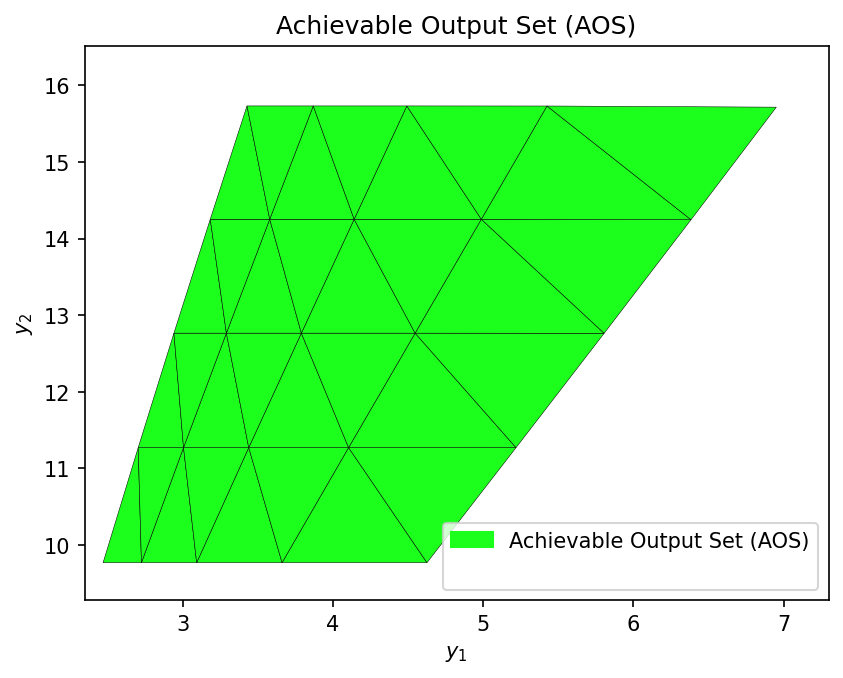

In [7]:
#---------------------- MULTIMODEL REPRESENTATION STUDY --------------------------------------------------

AIS_bounds =  np.array([[8e5, 1.3e6],[1.5e5, 3.5e5]]) #AIS bounds definition for the 2 inputs x 2 outputs case study

AIS_resolution =  [5,5] #AIS discretization definition 

AOS_reg = multimodel_rep(Multi, AIS_bounds, AIS_resolution) #Multimodel representation call

As the number of fibers were manipulated, consequently modifying the modules design, the above region is formed. In it, the AOS axes show the achieavable region formed by outcomes outlined in the multimodel function defined previously, (y<sub>1</sub> = CO<sub>2</sub> purity in mol% and y<sub>2</sub> = CO<sub>2</sub> recovery in %). 

Now, based on the region generated, the OI evaluation will provide a perspective on process' operability within the DOS outlined below. This calculation will provide insights on in how many of the cases studied (different module fiber packings) the process is operable within the desired region.
Now, based on the region generated, the OI evaluation will provide a perspective on process' operability within the DOS outlined below. This calculation will provide insights on in how many of the cases studied (different module fiber packings) the process is operable within the desired region.


| Desired Output Set (DOS)   |                        |
|---------------------------|------------------------------|
| CO<sub>2</sub> purity [mol%] (y1) | 3 - 7 |
| CO<sub>2</sub> recovery [%]  (y2)  | 11 - 15  |

## OI evaluation

Based on the region formed by the multimodal approach we propose below a desired region of operation. 

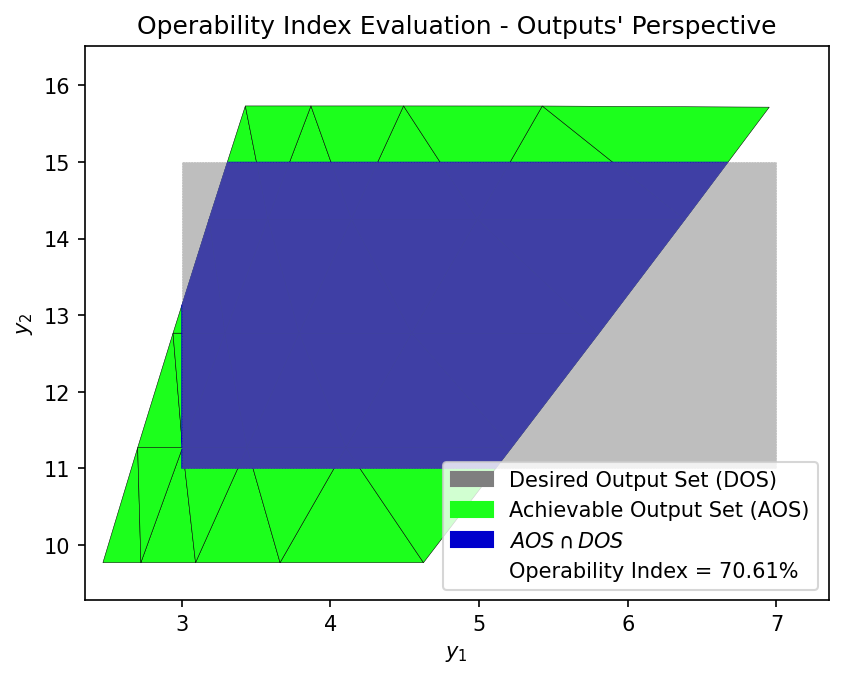

In [9]:
DOS_bounds =  np.array([[3, 7], 
                            [11, 15]])
OI = OI_eval(AOS_reg, DOS_bounds)

As seen in the figure above, the OI calculation indicates that in 70.61% of the evaluated cases, the process is <b>operable</b>.

This result highlights the usefulness of operability analysis as a diagnostic tool to evaluate the feasibility and flexibility of membrane-based direct air capture (DAC) systems. The knowledge gained from the OI not only quantifies the likelihood of achieving desired outcomes under varying conditions but also deepens our understanding of how gas separation membranes perform in removing CO<sub>2</sub> from ambient air. Given that the application of membrane separation for DAC is still in its early stages, the operability framework plays a critical role in guiding process development. It helps identifying favorable operating regions, determining membrane characteristics that most influence system performance, and setting realistic expectations for technology deployment. Most importantly, it provides a structured methodology to inform industrial partners on how to design, optimize, and scale up membrane-based DAC systems with greater confidence.


